### How do the perceived income moments correlate with other individual variables 

- this notebook inspects and runs regressions to look the covariants of individual perceived income moments
  - individual demogrpahics, level of income
  - probability of unemployment, other job-related expectations 
- it examiens both nominal and real income growth 


###  1. Loading and cleaning data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm 
from statsmodels.iolib.summary2 import summary_col

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

In [4]:
dataset.columns

Index(['date', 'year', 'month', 'userid', 'tenure', 'weight', 'Q1', 'Q2', 'Q3',
       'Q4new',
       ...
       'Q24_meanp50', 'Q24_varp75', 'Q24_varp25', 'Q24_varp50', 'Q24_rmean',
       'Q24_rvar', 'Q24_sd', 'Q24_disg', 'Q24_rsd', 'Q24_rdisg'],
      dtype='object', length=145)

In [5]:
## variable list by catogrories 

moms_nom = ['Q24_mean',
            'Q24_var']

moms_real = ['Q24_rmean',
             'Q24_rvar']

vars_demog = ['D6']   ## level of income, 11 groups 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'Q37']  ## these variables are only available for a sub sample 

vars_empexp = ['Q13new']  ## probability of unemployment 

vars_macroexp = ['Q6new']  ## stock market going up 


In [6]:
## subselect variables 

vars_all_reg = moms_nom + moms_real + vars_demog + vars_empexp + vars_macroexp
vars_all_reg_long = moms_nom + moms_real + vars_demog + vars_demog_sub + vars_empexp + vars_macroexp

## select dataset 

SCEM = dataset[vars_all_reg]
SCEM.describe(include='all')

SCEM_long = dataset[vars_all_reg_long]

In [7]:
## subselect variables 
vars_tiny_sub =['Q24_var',
                'Q24_mean',
                'Q13new',  ## prob (UE)  
                'D6']  ## income level 
vars_short_sub =  ['Q24_var',
                   'Q24_mean',
                   'Q1',
                   'Q2',
                   'Q3',
                   'Q4new',
                   'Q5new',
                   'Q6new',
                   'Q9_mean',
                   'Q13new',
                   'Q32',
                   'Q33',
                   'Q34',
                   'Q36',
                   'Q37',
                   'C1_mean',
                   'C1_var',
                   'D6']
vars_long_sub = ['Q24_var',
                 'Q24_mean',
                 'Q1',
                 'Q2',
                 'Q3',
                 'Q4new',
                 'Q5new',
                 'Q6new',
                 'Q9_mean',
                 'Q13new',
                 'Q32',
                 'Q33',
                 'Q34',
                 'Q36',
                 'Q37',
                 'Q38',
                 'Q41',
                 'Q42',
                 'Q43',
                 'Q43a',
                 'Q44',
                 'Q45b',
                 'C1_mean',
                 'C1_var',
                 'D6']

### 2. Correlation pattern 

In [8]:
SCEM = SCEM.rename(columns = {'D6':'HHinc',
                             'Q13new':'UEprob',
                             'Q6new':'Stkprob'})
SCEM_long =  SCEM_long.rename(columns = {'D6':'HHinc',
                             'Q13new':'UEprob',
                             'Q6new':'Stkprob'})

In [9]:
#pp = sns.pairplot(SCEM)

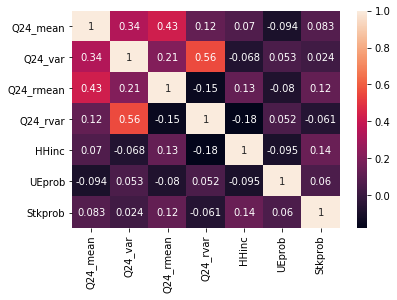

In [10]:
sns.heatmap(SCEM.corr(), 
            annot=True)

###  3. Regressions

I regress the individual earning growth expectations and uncertainty on household income level, perceived probability of unemployment next year and the perceived chance of stock market rise.

\begin{eqnarray}
\textrm{IncMom}_{i,t} = \alpha + \beta_0 \textrm{HH_{i,t}} + \beta_1 \textrm{Exp}_{i,t} + \epsilon_{i,t}
\end{eqnarray}

Findings from the regression 

- Higher household income earner has higher expected earning growth, lower perceived income risks, in both real and nominal terms;
- Higher perceived probability of unemployment is associated with lower expected income growth, higher income risks in both nominal and real terms
- Higher perceived chance of stock market increase is associated with higher expected income growth in both real and moninal terms. It is positively correlated with nominal earning risks but negatively correlated with real earning risks.  

In [65]:
## regressions 

dep_list =  moms_nom + moms_real 
indep_list = ['HHinc','UEprob','Stkprob']

SCEM = SCEM.dropna(how='any')

rs_list = {}

for i,mom in enumerate(dep_list):
    X = SCEM[indep_list]
    X = sm.add_constant(X)
    Y = SCEM[mom]
    model = sm.OLS(Y,X)
    rs_list[i] = model.fit()
    #print(rs_list[i].summary())
    
## combine different specifications 

rs_names = [rs_list[i] for i in range(len(rs_list))]
dfoutput = summary_col(rs_names,
                       float_format='%0.2f',
                       model_names=['nominal \n growth',
                                   'nominal \n variance',
                                   'real \n growth',
                                   'real \n variance'],
                       stars = True,
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput.title = 'perceived income risks'
print(dfoutput)

           perceived income risks
        nominal   nominal   real      real   
         growth   variance  growth   variance
---------------------------------------------
const   2.35***  3.36***   -3.20*** 24.93*** 
        (0.04)   (0.13)    (0.09)   (0.45)   
HHinc   0.04***  -0.09***  0.24***  -1.52*** 
        (0.01)   (0.02)    (0.01)   (0.05)   
UEprob  -0.01*** 0.01***   -0.02*** 0.04***  
        (0.00)   (0.00)    (0.00)   (0.01)   
Stkprob 0.01***  0.01***   0.02***  -0.05*** 
        (0.00)   (0.00)    (0.00)   (0.01)   
N       32861    32861     32861    32861    
R2      0.02     0.00      0.04     0.03     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


/Users/Myworld/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [78]:
## output tables 

beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}
\\begin{table}"""

endtex = "\end{table}\end{document}"

## write to latex 

f = open('../Tables/regression/reg1.tex', 'w')
f.write(beginningtex)
tb_ltx = dfoutput.tables[0].to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()

In [66]:
## other demographic controls 
more_contrl = indep_list + vars_demog_sub
SCEM_long = SCEM_long.dropna(how='any')


for mom in dep_list:
    X = SCEM_long[indep_list]
    X = sm.add_constant(X)
    Y = SCEM_long[mom]
    model = sm.OLS(Y,X)
    rs = model.fit()
    print(rs.summary())

                            OLS Regression Results                            
Dep. Variable:               Q24_mean   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     9.290
Date:                Thu, 21 Nov 2019   Prob (F-statistic):           5.29e-06
Time:                        20:14:00   Log-Likelihood:                -1234.8
No. Observations:                 563   AIC:                             2478.
Df Residuals:                     559   BIC:                             2495.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8261      0.368      4.968      0.0